# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/ > /dev/null # no output

    ERROR: Command errored out with exit status 1:
     command: /home/dohee/anaconda3/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-req-build-7f30jmou/setup.py'"'"'; __file__='"'"'/tmp/pip-req-build-7f30jmou/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-req-build-7f30jmou/pip-egg-info
         cwd: /tmp/pip-req-build-7f30jmou/
    Complete output (7 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-req-build-7f30jmou/setup.py", line 25, in <module>
        exec(open('pretrainedmodels/version.py').read())
      File "/home/dohee/anaconda3/lib/python3.7/codecs.py", line 904, in open
        file = builtins.open(filename, mode, buffering)
    FileNotFoundError: [Errno 2] No such file or directory: 'pretrainedmodels/version.py'
    -----------

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/pretrainedmodels.zip
../input/bengaliaicv19feather/test_image_data_2.feather
../input/bengaliaicv19feather/train_image_data_0.feather
../input/bengaliaicv19feather/test_image_data_3.feather
../input/bengaliaicv19feather/train_image_data_2.feather
../input/bengaliaicv19feather/train_image_data_3.feather
../input/bengaliaicv19feather/test_image_data_0.feather
../input/bengaliaicv19feather/test_image_data_1.feather
../input/bengaliaicv19feather/train_image_data_1.feather
../input/pretrainedmodels/pretrainedmodels-0.7.4/setup.cfg
../input/pretrainedmodels/pretrainedmodels-0.7.4/setup.py
../input/pretrainedmodels/pretrainedmodels-0.7.4/PKG-INFO
../input/pretrainedmodels/pretrainedmodels-0.7.4/README.md
../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels.egg-info/PKG-INFO
../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels.egg-info/SOURCES.txt
../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels.egg-info/requires.txt
../input/pretrainedmodels

In [4]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [5]:
debug=False
submission=False
batch_size=32*4
device='cuda:0'
out='.'
image_size=64*2
arch='pretrained'
model_name='densenet121'

In [6]:
import json

data = {
    "image_size": image_size,
    "threshold": 20.0,
    "arch": "pretrained",
    "model_name": model_name
}

In [7]:
with open(r'./save/args.json', 'w') as f:
    json.dump(data, f, indent=4)

In [8]:
datadir = Path('../input/bengaliai-cv19')
featherdir = Path('../input/bengaliaicv19feather')
outdir = Path('./save')

In [9]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [10]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [11]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)


image_df_list 4
CPU times: user 20.9 s, sys: 26.4 s, total: 47.3 s
Wall time: 9.6 s


In [12]:
os.listdir("../input/bengaliaicv19feather/")

['test_image_data_2.feather',
 'train_image_data_0.feather',
 'test_image_data_3.feather',
 'train_image_data_2.feather',
 'train_image_data_3.feather',
 'test_image_data_0.feather',
 'test_image_data_1.feather',
 'train_image_data_1.feather']

<a id="dataset"></a>
# Dataset

In [13]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [14]:
import numpy as np
import cv2

class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        
        
        #x = x.astype(np.float32) / 255.
        #x = x.astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_GRAY2BGR)
        x = x.astype(np.double)
        
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236, 3) label [15  9  5]


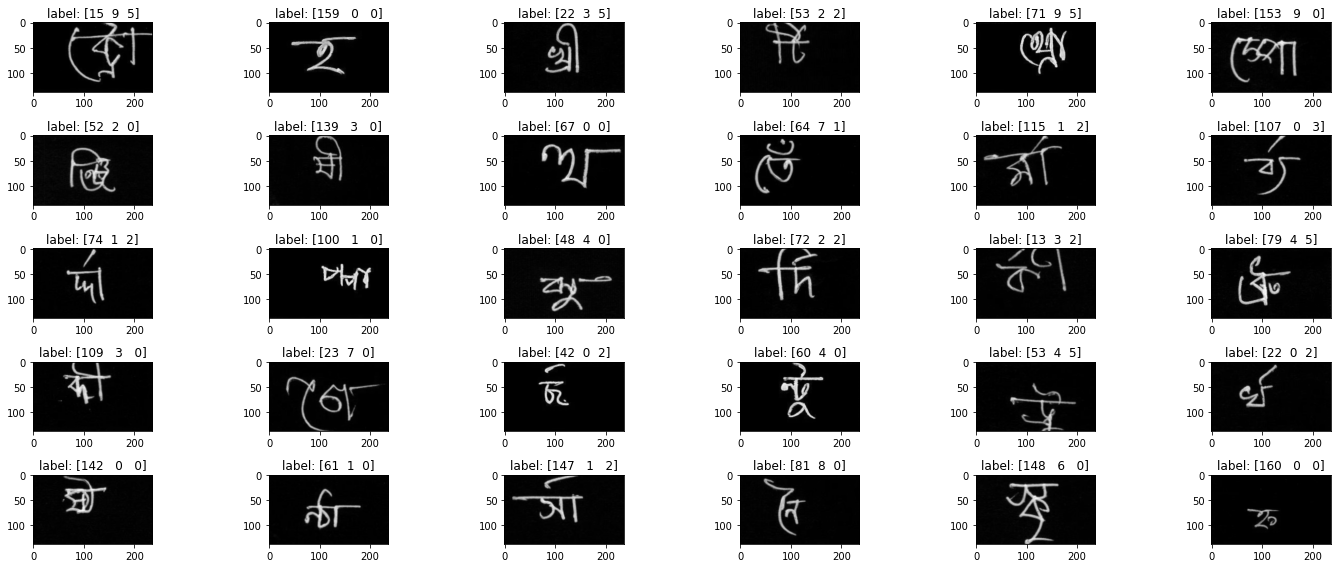

<Figure size 432x288 with 0 Axes>

In [16]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

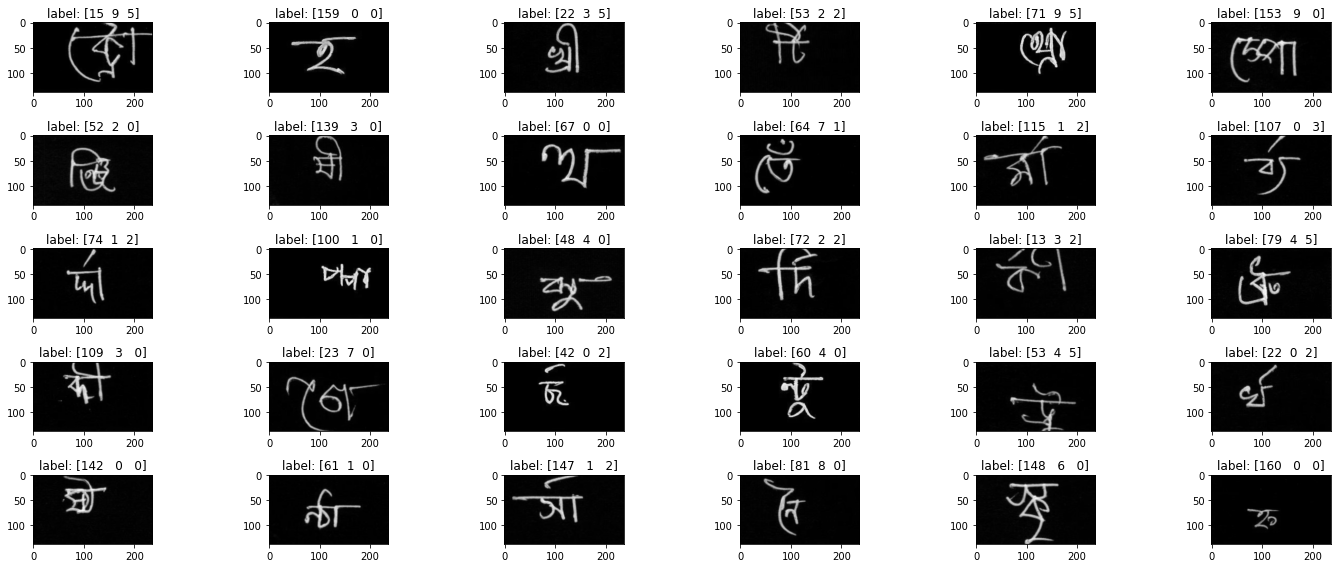

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    #if img.ndim == 3:
    #    img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 15 #7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    #assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array

def crop_char_image(image, threshold=5./255.):
    #assert image.ndim == 2
    is_black = np.copy(image[:,:,0])
    is_black = is_black > threshold
    is_black[:4,:] = 0
    is_black[-4:,:] = 0
    is_black[:,:4] = 0
    is_black[:,-4:] = 0

    #is_black = connected_comp(is_black)

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    
    left = np.argmax(is_black_horizontal)-4
    right = np.argmax(is_black_horizontal[::-1])+4
    top = np.argmax(is_black_vertical)+4
    bottom = np.argmax(is_black_vertical[::-1])-4
    height, width, _ = image.shape
    cropped_image = image[left:height - right, top:width - bottom, :]
    return cropped_image


def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

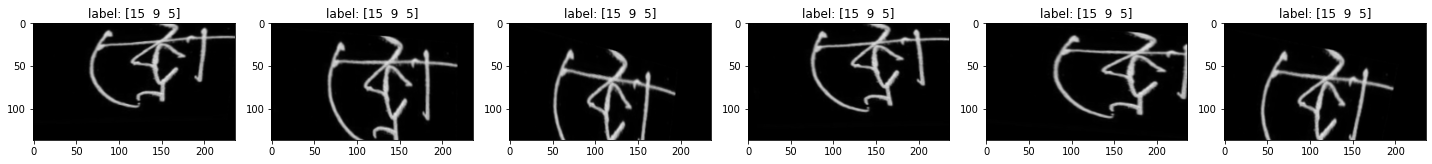

In [19]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

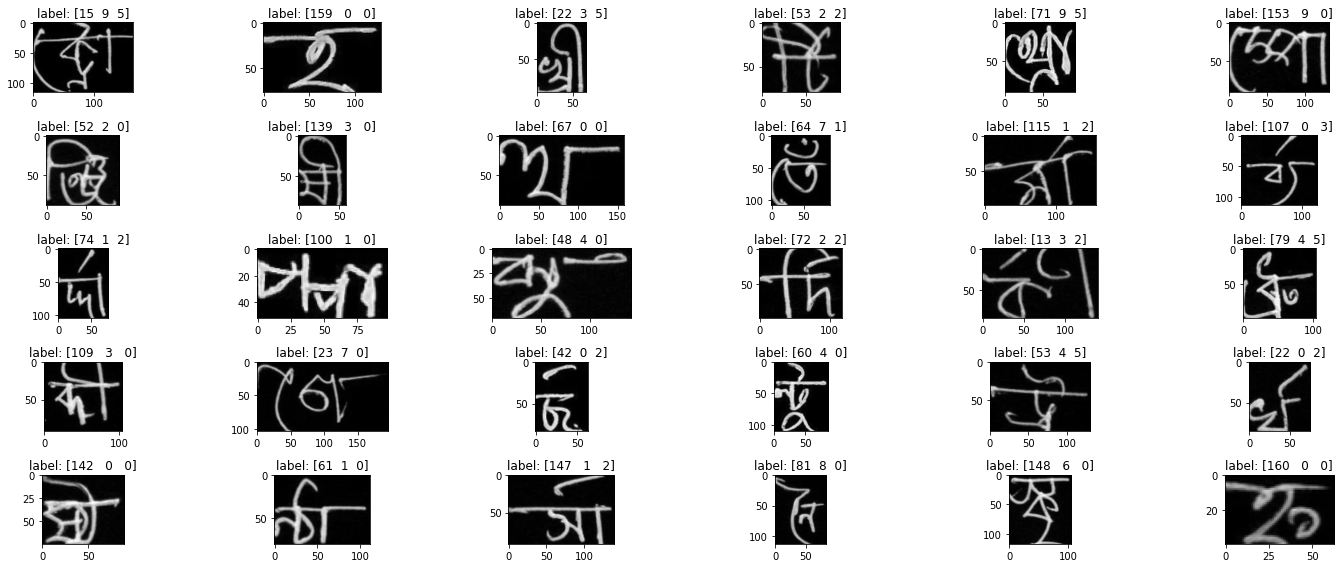

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i]
    ax.imshow(crop_char_image(image, threshold=20./255.), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

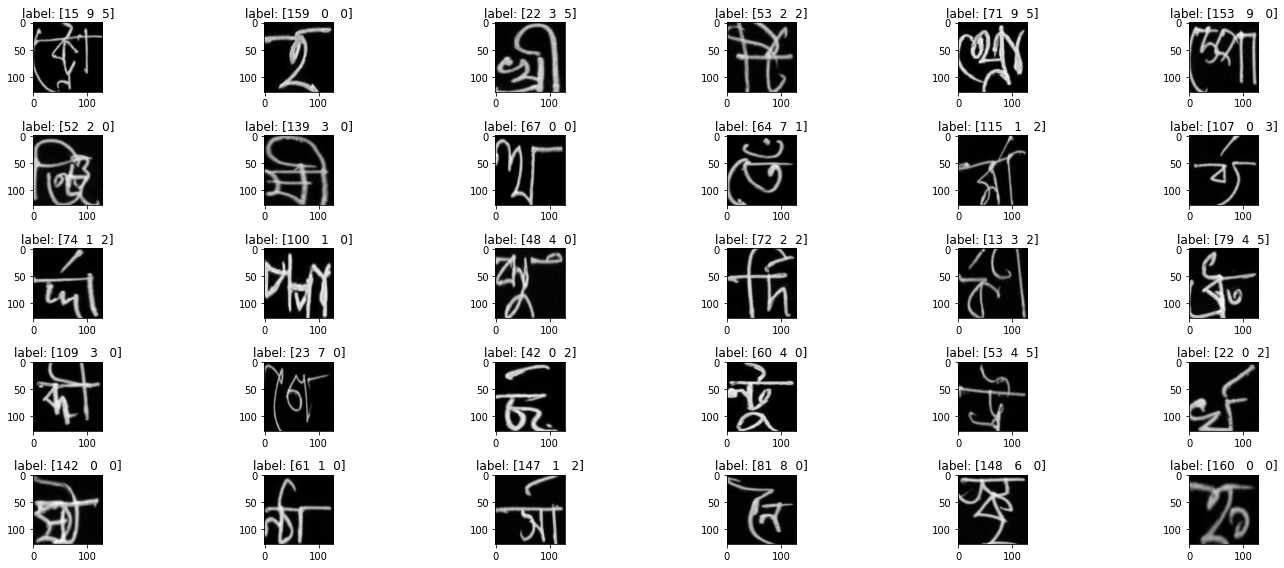

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i]
    ax.imshow(resize(crop_char_image(image, threshold=20./255.)), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [22]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            try:
                x = resize(x, size=self.size)
            except:
                print("resize error")
                x, y = example
                x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.double)
        #assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

        if self.normalize:
            x = (x.astype(np.double) - 0.0692) / 0.2051
            
            
        #if x.ndim == 2:
        #    x = x[None, :, :]
        x = np.einsum('ijk->kij', x)
        
        x = x.astype(np.double)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x
        
# class Transform:
#     def __init__(self, affine=True, crop=True, size=(64, 64),
#                  normalize=True, train=True, threshold=40.,
#                  sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
#                  grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
#                  piece_affine_ratio=0., ssr_ratio=0.):
#         self.affine = affine
#         self.crop = crop
#         self.size = size
#         self.normalize = normalize
#         self.train = train
#         self.threshold = threshold / 255.
#         self.sigma = sigma / 255.

#         self.blur_ratio = blur_ratio
#         self.noise_ratio = noise_ratio
#         self.cutout_ratio = cutout_ratio
#         self.grid_distortion_ratio = grid_distortion_ratio
#         self.elastic_distortion_ratio = elastic_distortion_ratio
#         self.random_brightness_ratio = random_brightness_ratio
#         self.piece_affine_ratio = piece_affine_ratio
#         self.ssr_ratio = ssr_ratio

#     def __call__(self, example):
#         if self.train:
#             x, y = example
#         else:
#             x = example
#         # --- Augmentation ---
#         if self.affine:
#             x = affine_image(x)

#         # --- Train/Test common preprocessing ---
#         if self.crop:
#             x = crop_char_image(x, threshold=self.threshold)
#         if self.size is not None:
#             x = resize(x, size=self.size)
#         if self.sigma > 0.:
#             x = add_gaussian_noise(x, sigma=self.sigma)

#         # albumentations...
#         x = x.astype(np.float32)
#         assert x.ndim == 2
#         # 1. blur
#         if _evaluate_ratio(self.blur_ratio):
#             r = np.random.uniform()
#             if r < 0.25:
#                 x = apply_aug(A.Blur(p=1.0), x)
#             elif r < 0.5:
#                 x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
#             elif r < 0.75:
#                 x = apply_aug(A.GaussianBlur(p=1.0), x)
#             else:
#                 x = apply_aug(A.MotionBlur(p=1.0), x)

#         if _evaluate_ratio(self.noise_ratio):
#             r = np.random.uniform()
#             if r < 0.50:
#                 x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
#             else:
#                 x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

#         if _evaluate_ratio(self.cutout_ratio):
#             # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
#             x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

#         if _evaluate_ratio(self.grid_distortion_ratio):
#             x = apply_aug(A.GridDistortion(p=1.0), x)

#         if _evaluate_ratio(self.elastic_distortion_ratio):
#             x = apply_aug(A.ElasticTransform(
#                 sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

#         if _evaluate_ratio(self.random_brightness_ratio):
#             # A.RandomBrightness(p=1.0)  # Deprecated...
#             # A.RandomContrast(p=1.0)    # Deprecated...
#             x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

#         if _evaluate_ratio(self.piece_affine_ratio):
#             x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

#         if _evaluate_ratio(self.ssr_ratio):
#             x = apply_aug(A.ShiftScaleRotate(
#                 shift_limit=0.0625,
#                 scale_limit=0.1,
#                 rotate_limit=30,
#                 p=1.0), x)

#         if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051
#         if x.ndim == 2:
#             x = x[None, :, :]
#         x = x.astype(np.float32)
#         if self.train:
#             y = y.astype(np.int64)
#             return x, y
#         else:
#             return x
        

In [23]:
train_transform = Transform(
    size=(image_size, image_size), threshold=20.,
    sigma=-1., blur_ratio=0.2, noise_ratio=0.2, cutout_ratio=0.2,
    grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
    piece_affine_ratio=0.2, ssr_ratio=0.2)
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

In [24]:
# nrow, ncol = 1, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[0]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

In [25]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[i]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [26]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [27]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [28]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [29]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [30]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='densenet121',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
        h = self.conv0(x)
        h = self.base_model.features(h)
        
        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
            
        return h

## Classifier

In [31]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.9997:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
    
#     print(lam)
#     print(data.shape)
#     print(indices)
#     print(bbx1, bbx2, bby1, bby2)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [32]:
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as AF

class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = AF.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [33]:
def GridMask_train(data):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]

    GridMaskCom = A.Compose([
    A.OneOf([
        GridMask(num_grid=(3,7), mode=0),
    #    GridMask(num_grid=(3,7), mode=1),
    #    GridMask(num_grid=(3,7), rotate=15, mode=0),
    #    GridMask(num_grid=(3,7), rotate=15, mode=1),
    #    GridMask(num_grid=(3,7), rotate=30, mode=0),
    #    GridMask(num_grid=(3,7), rotate=30, mode=1),
    #A.OneOf([
    #    GridMask(num_grid=(7,10), mode=2),        
    #    GridMask(num_grid=(7,10), rotate=15, mode=2),
    #    GridMask(num_grid=(7,10), rotate=30, mode=2)], p=1)
    ], p=0.25)
    ])
    
    img_list = []
    for i in range(data.size(0)):
        img = GridMaskCom(image=np.einsum('ijk->jki', shuffled_data[i]))['image']
        img_list.append(np.einsum('ijk->kij', img))
    return torch.tensor(img_list).cuda()

In [34]:
# for i in range(10):
#     plt.imshow(transforms_train(image=np.einsum('ijk->jki', train_dataset[0][0]))['image'])
#     plt.show()

In [35]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(6)
        if const<2:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data

        elif const<4:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data
        #else:
        #    x = GridMask_train(x)
        
        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        if const<4:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = loss_grapheme + loss_vowel + loss_consonant  
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = loss_grapheme + loss_vowel + loss_consonant
            
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
        
    
    def forward_val(self, x, y=None):

        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                
                
                
                pred = self.predictor(batch)
                
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

In [36]:
# import torch
# from torch import nn
# import torch.nn.functional as F
# from tqdm import tqdm


# def accuracy(y, t):
#     pred_label = torch.argmax(y, dim=1)
#     count = pred_label.shape[0]
#     correct = (pred_label == t).sum().type(torch.double)
#     acc = correct / count
#     return acc


# class BengaliClassifier(nn.Module):
#     def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
#         super(BengaliClassifier, self).__init__()
#         self.n_grapheme = n_grapheme
#         self.n_vowel = n_vowel
#         self.n_consonant = n_consonant
#         self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
#         self.predictor = predictor.float()
        
#         self.metrics_keys = [
#             'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
#             'acc_grapheme', 'acc_vowel', 'acc_consonant']

#     def forward(self, x, y=None):
#         const = np.random.rand()
#         if const<0.4:        
#             # mixup
#             data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#             x = data
#         elif const<0.8:
#             # cutmix
#             data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
#             x = data
#         pred = self.predictor(x)
        
        
#         if isinstance(pred, tuple):
#             assert len(pred) == 3
#             preds = pred
#         else:
#             assert pred.shape[1] == self.n_total_class
#             preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
#         if const<0.8:
#             # cutmix or mixup
#             targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
#             preds1, preds2, preds3 = preds[0], preds[1], preds[2]
#             #loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
#             #loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
#             #loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            
            
#             #criterion = nn.CrossEntropyLoss()
#             #loss_grapheme = lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) 
#             #loss_vowel = lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4)
#             #loss_consonant = lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)
            
            
#             loss = loss_grapheme + loss_vowel + loss_consonant  
            
            
            
            
#         else:
#             loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
#             loss_vowel = F.cross_entropy(preds[1], y[:, 1])
#             loss_consonant = F.cross_entropy(preds[2], y[:, 2])
#             loss = loss_grapheme + loss_vowel + loss_consonant
            
#         metrics = {
#             'loss': loss.item(),
#             'loss_grapheme': loss_grapheme.item(),
#             'loss_vowel': loss_vowel.item(),
#             'loss_consonant': loss_consonant.item(),
#             'acc_grapheme': accuracy(preds[0], y[:, 0]),
#             'acc_vowel': accuracy(preds[1], y[:, 1]),
#             'acc_consonant': accuracy(preds[2], y[:, 2]),
#         }
        
#         return loss, metrics, pred
    
    
    
#     def forward_val(self, x, y=None):

#         pred = self.predictor(x)
        
#         if isinstance(pred, tuple):
#             assert len(pred) == 3
#             preds = pred
#         else:
#             assert pred.shape[1] == self.n_total_class
#             preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
#         loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
#         loss_vowel = F.cross_entropy(preds[1], y[:, 1])
#         loss_consonant = F.cross_entropy(preds[2], y[:, 2])
#         loss = loss_grapheme + loss_vowel + loss_consonant
#         metrics = {
#             'loss': loss.item(),
#             'loss_grapheme': loss_grapheme.item(),
#             'loss_vowel': loss_vowel.item(),
#             'loss_consonant': loss_consonant.item(),
#             'acc_grapheme': accuracy(preds[0], y[:, 0]),
#             'acc_vowel': accuracy(preds[1], y[:, 1]),
#             'acc_consonant': accuracy(preds[2], y[:, 2]),
#         }
        
#         return loss, metrics, pred
    

#     def calc(self, data_loader):
#         device: torch.device = next(self.parameters()).device
#         self.eval()
#         output_list = []
#         with torch.no_grad():
#             for batch in tqdm(data_loader):
#                 # TODO: support general preprocessing.
#                 # If `data` is not `Data` instance, `to` method is not supported!
#                 batch = batch.to(device)
                
                
                
#                 pred = self.predictor(batch)
                
                
#                 output_list.append(pred)
#         output = torch.cat(output_list, dim=0)
#         preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
#         return preds

#     def predict_proba(self, data_loader):
#         preds = self.calc(data_loader)
#         return [F.softmax(p, dim=1) for p in preds]

#     def predict(self, data_loader):
#         preds = self.calc(data_loader)
#         pred_labels = [torch.argmax(p, dim=1) for p in preds]
#         return pred_labels


<a id="train"></a>
# Training code

## prepare data

In [37]:
n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.8)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

perm = np.random.RandomState(777).permutation(n_dataset)
print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...

predictor = PretrainedCNN(in_channels=3, out_dim=n_total, model_name=model_name, pretrained='imagenet')
#predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
print('predictor', type(predictor))




#load weights
# predictor.load_state_dict(torch.load(r"/home/dohee/kaggle/Bengali/code/save/model_000040.pt"))
# predictor.train()

classifier = BengaliClassifier(predictor).to(device)

#classifier = BengaliClassifier(predictor).to(device)


perm [ 95762  34576  11800 ... 183206 113455  63591]
train_dataset 160672 valid_dataset 40168
n_total 186


/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning:

nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.



predictor <class '__main__.PretrainedCNN'>


In [38]:
predictor

PretrainedCNN(
  (conv0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _D

In [39]:
# #load weights
# predictor.load_state_dict(torch.load(r"/home/dohee/kaggle/Bengali/code/save/model_000040.pt"))
# classifier = BengaliClassifier(predictor).to(device)

In [40]:
classifier

BengaliClassifier(
  (predictor): PretrainedCNN(
    (conv0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (base_model): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1),

## Ignite utility

pytorch-ignite utility class for training

In [41]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        
#         # mixup
#         data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#         #print(data.shape)
#         print(len(targets))
#         print(targets[0].shape)
#         print(y.shape)
        
#         print(targets)
#         print(y)

        
        loss, metrics, pred_y = classifier(x, y)
        
#         print(pred_y.shape)
#         print(pred_y)
#         print("---------------")
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'./save/model_{count:06}.pt',
                 interval=10, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            # self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [42]:
# def create_trainer(classifier, optimizer, device):
#     classifier.to(device)    
#     def update_fn(engine, batch):
#         classifier.train()
#         optimizer.zero_grad()

#         # batch = [elem.to(device) for elem in batch]
#         x, y = [elem.to(device) for elem in batch]        
#         x = x.float()
        
#         print(x.shape)
#         print(y.shape)
        
#         loss, metrics, pred_y = classifier(x, y)

In [43]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-10)


#load weights
predictor.load_state_dict(torch.load(r"/home/dohee/kaggle/Bengali/code/save/model_000040.pt"))
classifier = BengaliClassifier(predictor).to(device)


trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))

/home/dohee/anaconda3/envs/Bengali/lib/python3.6/site-packages/ignite/contrib/handlers/tqdm_logger.py:97: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [44]:
trainer.run(train_loader, max_epochs=100)

/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



epoch      1 train/loss  1.384207 train/loss_grapheme  0.711451 train/loss_vowel  0.397355 train/loss_consonant  0.275401 train/acc_grapheme  0.697191 train/acc_vowel  0.761831 train/acc_consonant  0.836105 train/recall  0.731901 valid/loss  0.191709 valid/loss_grapheme  0.101940 valid/loss_vowel  0.049703 valid/loss_consonant  0.040067 valid/acc_grapheme  0.975518 valid/acc_vowel  0.992630 valid/acc_consonant  0.992032 valid/recall  0.979449 lr  0.001000 elapsed_time  937.851329 


epoch      2 train/loss  1.453031 train/loss_grapheme  0.752836 train/loss_vowel  0.413933 train/loss_consonant  0.286262 train/acc_grapheme  0.705259 train/acc_vowel  0.773867 train/acc_consonant  0.842879 train/recall  0.741472 valid/loss  0.205703 valid/loss_grapheme  0.110547 valid/loss_vowel  0.051708 valid/loss_consonant  0.043448 valid/acc_grapheme  0.974796 valid/acc_vowel  0.993183 valid/acc_consonant  0.991690 valid/recall  0.980730 lr  0.001000 elapsed_time  1896.313577 


epoch      3 train/loss  1.461502 train/loss_grapheme  0.756764 train/loss_vowel  0.416130 train/loss_consonant  0.288609 train/acc_grapheme  0.688688 train/acc_vowel  0.758304 train/acc_consonant  0.832516 train/recall  0.724637 valid/loss  0.210031 valid/loss_grapheme  0.109664 valid/loss_vowel  0.057442 valid/loss_consonant  0.042925 valid/acc_grapheme  0.975443 valid/acc_vowel  0.992536 valid/acc_consonant  0.992287 valid/recall  0.980437 lr  0.001000 elapsed_time  2827.682766 


epoch      4 train/loss  1.434062 train/loss_grapheme  0.738763 train/loss_vowel  0.410195 train/loss_consonant  0.285104 train/acc_grapheme  0.707473 train/acc_vowel  0.774252 train/acc_consonant  0.843551 train/recall  0.743260 valid/loss  0.216588 valid/loss_grapheme  0.109861 valid/loss_vowel  0.059119 valid/loss_consonant  0.047608 valid/acc_grapheme  0.973098 valid/acc_vowel  0.992008 valid/acc_consonant  0.990310 valid/recall  0.979230 lr  0.001000 elapsed_time  3767.372408 


epoch      5 train/loss  1.395903 train/loss_grapheme  0.719464 train/loss_vowel  0.400429 train/loss_consonant  0.276010 train/acc_grapheme  0.695773 train/acc_vowel  0.761986 train/acc_consonant  0.835496 train/recall  0.733980 valid/loss  0.206508 valid/loss_grapheme  0.108222 valid/loss_vowel  0.057886 valid/loss_consonant  0.040400 valid/acc_grapheme  0.973820 valid/acc_vowel  0.992088 valid/acc_consonant  0.991809 valid/recall  0.978924 lr  0.001000 elapsed_time  4828.971740 


epoch      6 train/loss  1.315322 train/loss_grapheme  0.676845 train/loss_vowel  0.374649 train/loss_consonant  0.263828 train/acc_grapheme  0.710278 train/acc_vowel  0.775005 train/acc_consonant  0.843352 train/recall  0.744094 valid/loss  0.195139 valid/loss_grapheme  0.106348 valid/loss_vowel  0.045380 valid/loss_consonant  0.043411 valid/acc_grapheme  0.974964 valid/acc_vowel  0.993003 valid/acc_consonant  0.991728 valid/recall  0.981582 lr  0.001000 elapsed_time  5892.109119 


epoch      7 train/loss  1.413808 train/loss_grapheme  0.729668 train/loss_vowel  0.404727 train/loss_consonant  0.279414 train/acc_grapheme  0.700432 train/acc_vowel  0.765134 train/acc_consonant  0.836584 train/recall  0.732516 valid/loss  0.183742 valid/loss_grapheme  0.100947 valid/loss_vowel  0.045736 valid/loss_consonant  0.037059 valid/acc_grapheme  0.975294 valid/acc_vowel  0.992337 valid/acc_consonant  0.991988 valid/recall  0.980545 lr  0.001000 elapsed_time  6936.772055 


resize error
epoch      8 train/loss  1.459978 train/loss_grapheme  0.756055 train/loss_vowel  0.415659 train/loss_consonant  0.288264 train/acc_grapheme  0.682611 train/acc_vowel  0.752675 train/acc_consonant  0.828119 train/recall  0.720677 valid/loss  0.208410 valid/loss_grapheme  0.110555 valid/loss_vowel  0.057392 valid/loss_consonant  0.040464 valid/acc_grapheme  0.974572 valid/acc_vowel  0.991908 valid/acc_consonant  0.992237 valid/recall  0.980045 lr  0.001000 elapsed_time  7927.347969 


epoch      9 train/loss  1.467390 train/loss_grapheme  0.758299 train/loss_vowel  0.417823 train/loss_consonant  0.291267 train/acc_grapheme  0.707330 train/acc_vowel  0.777331 train/acc_consonant  0.844509 train/recall  0.745736 valid/loss  0.209828 valid/loss_grapheme  0.110554 valid/loss_vowel  0.055707 valid/loss_consonant  0.043568 valid/acc_grapheme  0.973676 valid/acc_vowel  0.992511 valid/acc_consonant  0.991914 valid/recall  0.979693 lr  0.001000 elapsed_time  8998.896568 


epoch     10 train/loss  1.364219 train/loss_grapheme  0.703622 train/loss_vowel  0.388944 train/loss_consonant  0.271652 train/acc_grapheme  0.717444 train/acc_vowel  0.778159 train/acc_consonant  0.845112 train/recall  0.750750 valid/loss  0.186132 valid/loss_grapheme  0.102472 valid/loss_vowel  0.043897 valid/loss_consonant  0.039762 valid/acc_grapheme  0.973900 valid/acc_vowel  0.992486 valid/acc_consonant  0.991516 valid/recall  0.980204 lr  0.001000 elapsed_time  10097.114211 


epoch     11 train/loss  1.485231 train/loss_grapheme  0.769422 train/loss_vowel  0.423191 train/loss_consonant  0.292618 train/acc_grapheme  0.700730 train/acc_vowel  0.771422 train/acc_consonant  0.840528 train/recall  0.737574 valid/loss  0.186309 valid/loss_grapheme  0.102838 valid/loss_vowel  0.043159 valid/loss_consonant  0.040312 valid/acc_grapheme  0.974298 valid/acc_vowel  0.991958 valid/acc_consonant  0.991590 valid/recall  0.977816 lr  0.001000 elapsed_time  11113.459911 


epoch     12 train/loss  1.370515 train/loss_grapheme  0.703746 train/loss_vowel  0.393792 train/loss_consonant  0.272977 train/acc_grapheme  0.702236 train/acc_vowel  0.766483 train/acc_consonant  0.839844 train/recall  0.735594 valid/loss  0.197024 valid/loss_grapheme  0.101885 valid/loss_vowel  0.054696 valid/loss_consonant  0.040443 valid/acc_grapheme  0.976314 valid/acc_vowel  0.992779 valid/acc_consonant  0.992624 valid/recall  0.980698 lr  0.000500 elapsed_time  12272.484329 


epoch     13 train/loss  1.399832 train/loss_grapheme  0.718471 train/loss_vowel  0.403432 train/loss_consonant  0.277930 train/acc_grapheme  0.708120 train/acc_vowel  0.772417 train/acc_consonant  0.841386 train/recall  0.741404 valid/loss  0.168388 valid/loss_grapheme  0.094051 valid/loss_vowel  0.039697 valid/loss_consonant  0.034640 valid/acc_grapheme  0.976762 valid/acc_vowel  0.993152 valid/acc_consonant  0.992201 valid/recall  0.982233 lr  0.000500 elapsed_time  13305.865571 


epoch     14 train/loss  1.360328 train/loss_grapheme  0.696917 train/loss_vowel  0.391635 train/loss_consonant  0.271776 train/acc_grapheme  0.709302 train/acc_vowel  0.773133 train/acc_consonant  0.842276 train/recall  0.742706 valid/loss  0.179009 valid/loss_grapheme  0.098523 valid/loss_vowel  0.044920 valid/loss_consonant  0.035566 valid/acc_grapheme  0.977085 valid/acc_vowel  0.992878 valid/acc_consonant  0.992635 valid/recall  0.982155 lr  0.000500 elapsed_time  14417.470970 


epoch     15 train/loss  1.377364 train/loss_grapheme  0.707253 train/loss_vowel  0.396627 train/loss_consonant  0.273484 train/acc_grapheme  0.692526 train/acc_vowel  0.759747 train/acc_consonant  0.835179 train/recall  0.727408 valid/loss  0.193399 valid/loss_grapheme  0.106879 valid/loss_vowel  0.046328 valid/loss_consonant  0.040192 valid/acc_grapheme  0.976164 valid/acc_vowel  0.993003 valid/acc_consonant  0.992699 valid/recall  0.981430 lr  0.000500 elapsed_time  15485.683751 


epoch     16 train/loss  1.479031 train/loss_grapheme  0.757859 train/loss_vowel  0.426855 train/loss_consonant  0.294317 train/acc_grapheme  0.691531 train/acc_vowel  0.763031 train/acc_consonant  0.834930 train/recall  0.730568 valid/loss  0.185187 valid/loss_grapheme  0.098077 valid/loss_vowel  0.047289 valid/loss_consonant  0.039821 valid/acc_grapheme  0.976507 valid/acc_vowel  0.993058 valid/acc_consonant  0.992126 valid/recall  0.981110 lr  0.000500 elapsed_time  16468.739548 


epoch     17 train/loss  1.400045 train/loss_grapheme  0.717974 train/loss_vowel  0.403812 train/loss_consonant  0.278259 train/acc_grapheme  0.709917 train/acc_vowel  0.775882 train/acc_consonant  0.845330 train/recall  0.745533 valid/loss  0.166438 valid/loss_grapheme  0.091329 valid/loss_vowel  0.038289 valid/loss_consonant  0.036820 valid/acc_grapheme  0.978528 valid/acc_vowel  0.993481 valid/acc_consonant  0.992610 valid/recall  0.982295 lr  0.000250 elapsed_time  17605.779651 


epoch     18 train/loss  1.371641 train/loss_grapheme  0.701303 train/loss_vowel  0.396081 train/loss_consonant  0.274257 train/acc_grapheme  0.713674 train/acc_vowel  0.778830 train/acc_consonant  0.847258 train/recall  0.749028 valid/loss  0.169931 valid/loss_grapheme  0.094408 valid/loss_vowel  0.039738 valid/loss_consonant  0.035785 valid/acc_grapheme  0.978006 valid/acc_vowel  0.993830 valid/acc_consonant  0.992561 valid/recall  0.982395 lr  0.000250 elapsed_time  18624.181110 


epoch     19 train/loss  1.365739 train/loss_grapheme  0.697102 train/loss_vowel  0.394647 train/loss_consonant  0.273990 train/acc_grapheme  0.706652 train/acc_vowel  0.772903 train/acc_consonant  0.843675 train/recall  0.740374 valid/loss  0.171868 valid/loss_grapheme  0.092259 valid/loss_vowel  0.043132 valid/loss_consonant  0.036476 valid/acc_grapheme  0.978647 valid/acc_vowel  0.993929 valid/acc_consonant  0.993208 valid/recall  0.982878 lr  0.000250 elapsed_time  19605.376166 


epoch     20 train/loss  1.370059 train/loss_grapheme  0.701836 train/loss_vowel  0.395365 train/loss_consonant  0.272857 train/acc_grapheme  0.702926 train/acc_vowel  0.768642 train/acc_consonant  0.840018 train/recall  0.740219 valid/loss  0.170113 valid/loss_grapheme  0.095061 valid/loss_vowel  0.039181 valid/loss_consonant  0.035871 valid/acc_grapheme  0.977209 valid/acc_vowel  0.993655 valid/acc_consonant  0.992610 valid/recall  0.982550 lr  0.000250 elapsed_time  20590.448547 


epoch     21 train/loss  1.327539 train/loss_grapheme  0.674080 train/loss_vowel  0.386190 train/loss_consonant  0.267269 train/acc_grapheme  0.700251 train/acc_vowel  0.762135 train/acc_consonant  0.835533 train/recall  0.733299 valid/loss  0.172657 valid/loss_grapheme  0.094845 valid/loss_vowel  0.041456 valid/loss_consonant  0.036357 valid/acc_grapheme  0.978180 valid/acc_vowel  0.993133 valid/acc_consonant  0.992381 valid/recall  0.981491 lr  0.000250 elapsed_time  21687.199119 


epoch     22 train/loss  1.349191 train/loss_grapheme  0.689437 train/loss_vowel  0.391198 train/loss_consonant  0.268557 train/acc_grapheme  0.707715 train/acc_vowel  0.772592 train/acc_consonant  0.844061 train/recall  0.743747 valid/loss  0.162951 valid/loss_grapheme  0.088803 valid/loss_vowel  0.038928 valid/loss_consonant  0.035221 valid/acc_grapheme  0.978827 valid/acc_vowel  0.994078 valid/acc_consonant  0.993083 valid/recall  0.982657 lr  0.000125 elapsed_time  22693.727710 


resize error
epoch     23 train/loss  1.377776 train/loss_grapheme  0.705264 train/loss_vowel  0.397545 train/loss_consonant  0.274967 train/acc_grapheme  0.696805 train/acc_vowel  0.763628 train/acc_consonant  0.837244 train/recall  0.733667 valid/loss  0.175564 valid/loss_grapheme  0.097277 valid/loss_vowel  0.040961 valid/loss_consonant  0.037327 valid/acc_grapheme  0.977632 valid/acc_vowel  0.993500 valid/acc_consonant  0.992561 valid/recall  0.982229 lr  0.000125 elapsed_time  23700.249326 


epoch     24 train/loss  1.333031 train/loss_grapheme  0.676332 train/loss_vowel  0.387609 train/loss_consonant  0.269091 train/acc_grapheme  0.707087 train/acc_vowel  0.771080 train/acc_consonant  0.842462 train/recall  0.741418 valid/loss  0.163288 valid/loss_grapheme  0.089356 valid/loss_vowel  0.038995 valid/loss_consonant  0.034937 valid/acc_grapheme  0.978951 valid/acc_vowel  0.993699 valid/acc_consonant  0.992934 valid/recall  0.982880 lr  0.000125 elapsed_time  24726.407163 


epoch     25 train/loss  1.338516 train/loss_grapheme  0.680831 train/loss_vowel  0.389167 train/loss_consonant  0.268519 train/acc_grapheme  0.702111 train/acc_vowel  0.765669 train/acc_consonant  0.838805 train/recall  0.735203 valid/loss  0.154326 valid/loss_grapheme  0.087419 valid/loss_vowel  0.034060 valid/loss_consonant  0.032847 valid/acc_grapheme  0.979225 valid/acc_vowel  0.993631 valid/acc_consonant  0.992859 valid/recall  0.983170 lr  0.000125 elapsed_time  25967.902555 


epoch     26 train/loss  1.369283 train/loss_grapheme  0.697426 train/loss_vowel  0.397907 train/loss_consonant  0.273951 train/acc_grapheme  0.695959 train/acc_vowel  0.760394 train/acc_consonant  0.834973 train/recall  0.727330 valid/loss  0.170390 valid/loss_grapheme  0.092736 valid/loss_vowel  0.040861 valid/loss_consonant  0.036793 valid/acc_grapheme  0.978901 valid/acc_vowel  0.993780 valid/acc_consonant  0.992804 valid/recall  0.982906 lr  0.000125 elapsed_time  27035.624639 


epoch     27 train/loss  1.327870 train/loss_grapheme  0.675212 train/loss_vowel  0.386139 train/loss_consonant  0.266519 train/acc_grapheme  0.702870 train/acc_vowel  0.764847 train/acc_consonant  0.837772 train/recall  0.734947 valid/loss  0.163317 valid/loss_grapheme  0.093574 valid/loss_vowel  0.035400 valid/loss_consonant  0.034343 valid/acc_grapheme  0.978453 valid/acc_vowel  0.993904 valid/acc_consonant  0.992834 valid/recall  0.983705 lr  0.000063 elapsed_time  28047.831589 


epoch     28 train/loss  1.380984 train/loss_grapheme  0.705500 train/loss_vowel  0.401606 train/loss_consonant  0.273878 train/acc_grapheme  0.702534 train/acc_vowel  0.769127 train/acc_consonant  0.842114 train/recall  0.738290 valid/loss  0.170000 valid/loss_grapheme  0.094441 valid/loss_vowel  0.039520 valid/loss_consonant  0.036039 valid/acc_grapheme  0.977732 valid/acc_vowel  0.993326 valid/acc_consonant  0.992854 valid/recall  0.983592 lr  0.000063 elapsed_time  29063.850718 


epoch     29 train/loss  1.290461 train/loss_grapheme  0.654578 train/loss_vowel  0.376301 train/loss_consonant  0.259583 train/acc_grapheme  0.709706 train/acc_vowel  0.772181 train/acc_consonant  0.843321 train/recall  0.739953 valid/loss  0.164328 valid/loss_grapheme  0.090701 valid/loss_vowel  0.040179 valid/loss_consonant  0.033449 valid/acc_grapheme  0.979449 valid/acc_vowel  0.993730 valid/acc_consonant  0.993183 valid/recall  0.983731 lr  0.000063 elapsed_time  30134.217328 


resize error
epoch     30 train/loss  1.327036 train/loss_grapheme  0.675902 train/loss_vowel  0.385699 train/loss_consonant  0.265435 train/acc_grapheme  0.686847 train/acc_vowel  0.749353 train/acc_consonant  0.829761 train/recall  0.720007 valid/loss  0.173730 valid/loss_grapheme  0.093697 valid/loss_vowel  0.043698 valid/loss_consonant  0.036335 valid/acc_grapheme  0.979001 valid/acc_vowel  0.993774 valid/acc_consonant  0.993202 valid/recall  0.983130 lr  0.000063 elapsed_time  31139.040089 


epoch     31 train/loss  1.407064 train/loss_grapheme  0.717797 train/loss_vowel  0.409041 train/loss_consonant  0.280226 train/acc_grapheme  0.709805 train/acc_vowel  0.772536 train/acc_consonant  0.843781 train/recall  0.742330 valid/loss  0.163651 valid/loss_grapheme  0.091010 valid/loss_vowel  0.038453 valid/loss_consonant  0.034188 valid/acc_grapheme  0.978976 valid/acc_vowel  0.993799 valid/acc_consonant  0.993009 valid/recall  0.983350 lr  0.000063 elapsed_time  32158.736457 


epoch     32 train/loss  1.286242 train/loss_grapheme  0.654502 train/loss_vowel  0.374984 train/loss_consonant  0.256756 train/acc_grapheme  0.708126 train/acc_vowel  0.770458 train/acc_consonant  0.842382 train/recall  0.742008 valid/loss  0.163159 valid/loss_grapheme  0.089811 valid/loss_vowel  0.038384 valid/loss_consonant  0.034964 valid/acc_grapheme  0.978802 valid/acc_vowel  0.993830 valid/acc_consonant  0.993127 valid/recall  0.982795 lr  0.000063 elapsed_time  33286.777538 


epoch     33 train/loss  1.281366 train/loss_grapheme  0.650928 train/loss_vowel  0.372786 train/loss_consonant  0.257652 train/acc_grapheme  0.718526 train/acc_vowel  0.779266 train/acc_consonant  0.845647 train/recall  0.749329 valid/loss  0.159063 valid/loss_grapheme  0.091152 valid/loss_vowel  0.034645 valid/loss_consonant  0.033267 valid/acc_grapheme  0.978802 valid/acc_vowel  0.993606 valid/acc_consonant  0.993083 valid/recall  0.982959 lr  0.000063 elapsed_time  34248.296334 


epoch     34 train/loss  1.361906 train/loss_grapheme  0.692956 train/loss_vowel  0.396223 train/loss_consonant  0.272727 train/acc_grapheme  0.722177 train/acc_vowel  0.782643 train/acc_consonant  0.849647 train/recall  0.754827 valid/loss  0.159008 valid/loss_grapheme  0.090071 valid/loss_vowel  0.035541 valid/loss_consonant  0.033395 valid/acc_grapheme  0.979250 valid/acc_vowel  0.993854 valid/acc_consonant  0.993232 valid/recall  0.983089 lr  0.000063 elapsed_time  35204.394494 


epoch     35 train/loss  1.329308 train/loss_grapheme  0.673981 train/loss_vowel  0.388178 train/loss_consonant  0.267149 train/acc_grapheme  0.704039 train/acc_vowel  0.764319 train/acc_consonant  0.838482 train/recall  0.734637 valid/loss  0.160243 valid/loss_grapheme  0.088860 valid/loss_vowel  0.036731 valid/loss_consonant  0.034652 valid/acc_grapheme  0.979299 valid/acc_vowel  0.993675 valid/acc_consonant  0.993058 valid/recall  0.983729 lr  0.000063 elapsed_time  36177.850101 


epoch     36 train/loss  1.306467 train/loss_grapheme  0.661437 train/loss_vowel  0.380054 train/loss_consonant  0.264976 train/acc_grapheme  0.712275 train/acc_vowel  0.772946 train/acc_consonant  0.843277 train/recall  0.744217 valid/loss  0.169748 valid/loss_grapheme  0.091988 valid/loss_vowel  0.042191 valid/loss_consonant  0.035568 valid/acc_grapheme  0.978876 valid/acc_vowel  0.994103 valid/acc_consonant  0.993208 valid/recall  0.983315 lr  0.000063 elapsed_time  37240.609862 


epoch     37 train/loss  1.323109 train/loss_grapheme  0.672391 train/loss_vowel  0.385288 train/loss_consonant  0.265430 train/acc_grapheme  0.695984 train/acc_vowel  0.757271 train/acc_consonant  0.832759 train/recall  0.728188 valid/loss  0.179318 valid/loss_grapheme  0.093932 valid/loss_vowel  0.047136 valid/loss_consonant  0.038250 valid/acc_grapheme  0.978478 valid/acc_vowel  0.993699 valid/acc_consonant  0.992804 valid/recall  0.982870 lr  0.000063 elapsed_time  38282.463639 


epoch     38 train/loss  1.352511 train/loss_grapheme  0.687635 train/loss_vowel  0.394317 train/loss_consonant  0.270559 train/acc_grapheme  0.713960 train/acc_vowel  0.777673 train/acc_consonant  0.846207 train/recall  0.744680 valid/loss  0.180408 valid/loss_grapheme  0.096122 valid/loss_vowel  0.046175 valid/loss_consonant  0.038111 valid/acc_grapheme  0.979573 valid/acc_vowel  0.993699 valid/acc_consonant  0.993102 valid/recall  0.983455 lr  0.000063 elapsed_time  39332.574160 


epoch     39 train/loss  1.307784 train/loss_grapheme  0.664646 train/loss_vowel  0.380189 train/loss_consonant  0.262949 train/acc_grapheme  0.719814 train/acc_vowel  0.781443 train/acc_consonant  0.847830 train/recall  0.753426 valid/loss  0.162886 valid/loss_grapheme  0.089656 valid/loss_vowel  0.038858 valid/loss_consonant  0.034372 valid/acc_grapheme  0.979274 valid/acc_vowel  0.993680 valid/acc_consonant  0.993152 valid/recall  0.983367 lr  0.000031 elapsed_time  40358.179540 


epoch     40 train/loss  1.325416 train/loss_grapheme  0.674838 train/loss_vowel  0.385131 train/loss_consonant  0.265447 train/acc_grapheme  0.700152 train/acc_vowel  0.763790 train/acc_consonant  0.837934 train/recall  0.734792 valid/loss  0.166497 valid/loss_grapheme  0.090054 valid/loss_vowel  0.040949 valid/loss_consonant  0.035495 valid/acc_grapheme  0.979673 valid/acc_vowel  0.993830 valid/acc_consonant  0.993077 valid/recall  0.983785 lr  0.000031 elapsed_time  41325.647173 


epoch     41 train/loss  1.380779 train/loss_grapheme  0.701836 train/loss_vowel  0.402329 train/loss_consonant  0.276613 train/acc_grapheme  0.701464 train/acc_vowel  0.765843 train/acc_consonant  0.837723 train/recall  0.735486 valid/loss  0.179874 valid/loss_grapheme  0.096656 valid/loss_vowel  0.045338 valid/loss_consonant  0.037880 valid/acc_grapheme  0.978404 valid/acc_vowel  0.993575 valid/acc_consonant  0.992605 valid/recall  0.983331 lr  0.000031 elapsed_time  42349.842574 


epoch     42 train/loss  1.343335 train/loss_grapheme  0.683157 train/loss_vowel  0.390774 train/loss_consonant  0.269404 train/acc_grapheme  0.712511 train/acc_vowel  0.776386 train/acc_consonant  0.845193 train/recall  0.744828 valid/loss  0.162683 valid/loss_grapheme  0.092424 valid/loss_vowel  0.036433 valid/loss_consonant  0.033826 valid/acc_grapheme  0.978603 valid/acc_vowel  0.993500 valid/acc_consonant  0.992406 valid/recall  0.982453 lr  0.000031 elapsed_time  43368.239265 


epoch     43 train/loss  1.291210 train/loss_grapheme  0.653231 train/loss_vowel  0.377529 train/loss_consonant  0.260450 train/acc_grapheme  0.703660 train/acc_vowel  0.764624 train/acc_consonant  0.839694 train/recall  0.734009 valid/loss  0.160087 valid/loss_grapheme  0.088391 valid/loss_vowel  0.036332 valid/loss_consonant  0.035365 valid/acc_grapheme  0.979399 valid/acc_vowel  0.993774 valid/acc_consonant  0.992804 valid/recall  0.983487 lr  0.000031 elapsed_time  44353.650486 


epoch     44 train/loss  1.328530 train/loss_grapheme  0.677462 train/loss_vowel  0.386029 train/loss_consonant  0.265039 train/acc_grapheme  0.717581 train/acc_vowel  0.777412 train/acc_consonant  0.848179 train/recall  0.750345 valid/loss  0.165954 valid/loss_grapheme  0.092533 valid/loss_vowel  0.039210 valid/loss_consonant  0.034212 valid/acc_grapheme  0.979598 valid/acc_vowel  0.994029 valid/acc_consonant  0.993307 valid/recall  0.983822 lr  0.000016 elapsed_time  45379.296456 


epoch     45 train/loss  1.279164 train/loss_grapheme  0.645945 train/loss_vowel  0.374493 train/loss_consonant  0.258726 train/acc_grapheme  0.725567 train/acc_vowel  0.784435 train/acc_consonant  0.850207 train/recall  0.757250 valid/loss  0.172728 valid/loss_grapheme  0.094087 valid/loss_vowel  0.042640 valid/loss_consonant  0.036001 valid/acc_grapheme  0.979474 valid/acc_vowel  0.993954 valid/acc_consonant  0.993158 valid/recall  0.983585 lr  0.000016 elapsed_time  46367.058036 


resize error
epoch     46 train/loss  1.262555 train/loss_grapheme  0.640251 train/loss_vowel  0.368425 train/loss_consonant  0.253879 train/acc_grapheme  0.726836 train/acc_vowel  0.784659 train/acc_consonant  0.851469 train/recall  0.757961 valid/loss  0.164161 valid/loss_grapheme  0.090263 valid/loss_vowel  0.038775 valid/loss_consonant  0.035124 valid/acc_grapheme  0.979573 valid/acc_vowel  0.993849 valid/acc_consonant  0.993326 valid/recall  0.982760 lr  0.000016 elapsed_time  47418.868016 


epoch     47 train/loss  1.321509 train/loss_grapheme  0.672289 train/loss_vowel  0.385845 train/loss_consonant  0.263375 train/acc_grapheme  0.716013 train/acc_vowel  0.775285 train/acc_consonant  0.845672 train/recall  0.747975 valid/loss  0.153662 valid/loss_grapheme  0.088032 valid/loss_vowel  0.032827 valid/loss_consonant  0.032802 valid/acc_grapheme  0.979648 valid/acc_vowel  0.993675 valid/acc_consonant  0.993003 valid/recall  0.982916 lr  0.000016 elapsed_time  48494.147716 


epoch     48 train/loss  1.294293 train/loss_grapheme  0.657473 train/loss_vowel  0.377497 train/loss_consonant  0.259323 train/acc_grapheme  0.694902 train/acc_vowel  0.758671 train/acc_consonant  0.834631 train/recall  0.727207 valid/loss  0.163141 valid/loss_grapheme  0.089291 valid/loss_vowel  0.038754 valid/loss_consonant  0.035096 valid/acc_grapheme  0.979299 valid/acc_vowel  0.993874 valid/acc_consonant  0.993183 valid/recall  0.983221 lr  0.000016 elapsed_time  49554.034959 


epoch     49 train/loss  1.313552 train/loss_grapheme  0.666153 train/loss_vowel  0.381906 train/loss_consonant  0.265493 train/acc_grapheme  0.708872 train/acc_vowel  0.772088 train/acc_consonant  0.843464 train/recall  0.741660 valid/loss  0.171207 valid/loss_grapheme  0.093836 valid/loss_vowel  0.042476 valid/loss_consonant  0.034894 valid/acc_grapheme  0.979872 valid/acc_vowel  0.993625 valid/acc_consonant  0.993332 valid/recall  0.983934 lr  0.000016 elapsed_time  50523.247525 


epoch     50 train/loss  1.276432 train/loss_grapheme  0.646340 train/loss_vowel  0.372813 train/loss_consonant  0.257280 train/acc_grapheme  0.702466 train/acc_vowel  0.765718 train/acc_consonant  0.837468 train/recall  0.734747 valid/loss  0.154027 valid/loss_grapheme  0.088643 valid/loss_vowel  0.032493 valid/loss_consonant  0.032891 valid/acc_grapheme  0.979548 valid/acc_vowel  0.993451 valid/acc_consonant  0.993177 valid/recall  0.982742 lr  0.000016 elapsed_time  51624.431103 


epoch     51 train/loss  1.288897 train/loss_grapheme  0.654575 train/loss_vowel  0.375337 train/loss_consonant  0.258985 train/acc_grapheme  0.724659 train/acc_vowel  0.783458 train/acc_consonant  0.850238 train/recall  0.754955 valid/loss  0.164526 valid/loss_grapheme  0.090467 valid/loss_vowel  0.039442 valid/loss_consonant  0.034616 valid/acc_grapheme  0.979424 valid/acc_vowel  0.993824 valid/acc_consonant  0.993332 valid/recall  0.983418 lr  0.000016 elapsed_time  52558.831062 


epoch     52 train/loss  1.389576 train/loss_grapheme  0.708328 train/loss_vowel  0.403671 train/loss_consonant  0.277577 train/acc_grapheme  0.693129 train/acc_vowel  0.759647 train/acc_consonant  0.835185 train/recall  0.727980 valid/loss  0.157431 valid/loss_grapheme  0.088599 valid/loss_vowel  0.035168 valid/loss_consonant  0.033665 valid/acc_grapheme  0.979324 valid/acc_vowel  0.993650 valid/acc_consonant  0.992810 valid/recall  0.983016 lr  0.000008 elapsed_time  53602.728240 


epoch     53 train/loss  1.303975 train/loss_grapheme  0.659217 train/loss_vowel  0.382031 train/loss_consonant  0.262726 train/acc_grapheme  0.709507 train/acc_vowel  0.771895 train/acc_consonant  0.842618 train/recall  0.741035 valid/loss  0.164743 valid/loss_grapheme  0.092512 valid/loss_vowel  0.037695 valid/loss_consonant  0.034535 valid/acc_grapheme  0.978528 valid/acc_vowel  0.993600 valid/acc_consonant  0.992829 valid/recall  0.982552 lr  0.000008 elapsed_time  54577.880503 


epoch     54 train/loss  1.244906 train/loss_grapheme  0.629879 train/loss_vowel  0.362626 train/loss_consonant  0.252401 train/acc_grapheme  0.720573 train/acc_vowel  0.779689 train/acc_consonant  0.848477 train/recall  0.752211 valid/loss  0.163952 valid/loss_grapheme  0.093887 valid/loss_vowel  0.035883 valid/loss_consonant  0.034182 valid/acc_grapheme  0.978429 valid/acc_vowel  0.993923 valid/acc_consonant  0.992953 valid/recall  0.983218 lr  0.000008 elapsed_time  55621.746170 


epoch     55 train/loss  1.262234 train/loss_grapheme  0.640476 train/loss_vowel  0.367880 train/loss_consonant  0.253878 train/acc_grapheme  0.708673 train/acc_vowel  0.769220 train/acc_consonant  0.841293 train/recall  0.738902 valid/loss  0.169111 valid/loss_grapheme  0.092693 valid/loss_vowel  0.041450 valid/loss_consonant  0.034967 valid/acc_grapheme  0.979772 valid/acc_vowel  0.993824 valid/acc_consonant  0.993307 valid/recall  0.983710 lr  0.000008 elapsed_time  56655.946603 


epoch     56 train/loss  1.327715 train/loss_grapheme  0.675143 train/loss_vowel  0.386901 train/loss_consonant  0.265670 train/acc_grapheme  0.705109 train/acc_vowel  0.771142 train/acc_consonant  0.842002 train/recall  0.741126 valid/loss  0.181559 valid/loss_grapheme  0.097656 valid/loss_vowel  0.045941 valid/loss_consonant  0.037962 valid/acc_grapheme  0.979349 valid/acc_vowel  0.993749 valid/acc_consonant  0.993177 valid/recall  0.983760 lr  0.000008 elapsed_time  57640.209136 


epoch     57 train/loss  1.309128 train/loss_grapheme  0.665765 train/loss_vowel  0.381365 train/loss_consonant  0.261997 train/acc_grapheme  0.718731 train/acc_vowel  0.779726 train/acc_consonant  0.849728 train/recall  0.752479 valid/loss  0.169711 valid/loss_grapheme  0.091527 valid/loss_vowel  0.042618 valid/loss_consonant  0.035566 valid/acc_grapheme  0.979374 valid/acc_vowel  0.993675 valid/acc_consonant  0.993053 valid/recall  0.983318 lr  0.000008 elapsed_time  58689.390483 


epoch     58 train/loss  1.284052 train/loss_grapheme  0.649936 train/loss_vowel  0.374575 train/loss_consonant  0.259541 train/acc_grapheme  0.718358 train/acc_vowel  0.779987 train/acc_consonant  0.847613 train/recall  0.750481 valid/loss  0.156947 valid/loss_grapheme  0.088105 valid/loss_vowel  0.035400 valid/loss_consonant  0.033441 valid/acc_grapheme  0.979374 valid/acc_vowel  0.993899 valid/acc_consonant  0.993003 valid/recall  0.983178 lr  0.000008 elapsed_time  59666.684349 


resize error
epoch     59 train/loss  1.275493 train/loss_grapheme  0.647411 train/loss_vowel  0.371441 train/loss_consonant  0.256641 train/acc_grapheme  0.719179 train/acc_vowel  0.780193 train/acc_consonant  0.848477 train/recall  0.750295 valid/loss  0.172666 valid/loss_grapheme  0.091625 valid/loss_vowel  0.044445 valid/loss_consonant  0.036597 valid/acc_grapheme  0.979349 valid/acc_vowel  0.993650 valid/acc_consonant  0.993053 valid/recall  0.983308 lr  0.000008 elapsed_time  60662.020714 


resize error
epoch     60 train/loss  1.288013 train/loss_grapheme  0.652734 train/loss_vowel  0.376455 train/loss_consonant  0.258824 train/acc_grapheme  0.715379 train/acc_vowel  0.775994 train/acc_consonant  0.847426 train/recall  0.747092 valid/loss  0.163012 valid/loss_grapheme  0.091195 valid/loss_vowel  0.038036 valid/loss_consonant  0.033782 valid/acc_grapheme  0.979175 valid/acc_vowel  0.993675 valid/acc_consonant  0.993028 valid/recall  0.983213 lr  0.000004 elapsed_time  61678.656737 


epoch     61 train/loss  1.305383 train/loss_grapheme  0.664301 train/loss_vowel  0.379490 train/loss_consonant  0.261592 train/acc_grapheme  0.726643 train/acc_vowel  0.785529 train/acc_consonant  0.849995 train/recall  0.758709 valid/loss  0.163705 valid/loss_grapheme  0.089964 valid/loss_vowel  0.038870 valid/loss_consonant  0.034871 valid/acc_grapheme  0.979374 valid/acc_vowel  0.993699 valid/acc_consonant  0.993208 valid/recall  0.983467 lr  0.000004 elapsed_time  62658.412155 


epoch     62 train/loss  1.311072 train/loss_grapheme  0.666280 train/loss_vowel  0.382017 train/loss_consonant  0.262774 train/acc_grapheme  0.696071 train/acc_vowel  0.760294 train/acc_consonant  0.836317 train/recall  0.729686 valid/loss  0.157869 valid/loss_grapheme  0.088038 valid/loss_vowel  0.036590 valid/loss_consonant  0.033242 valid/acc_grapheme  0.979474 valid/acc_vowel  0.993824 valid/acc_consonant  0.993077 valid/recall  0.983359 lr  0.000004 elapsed_time  63697.402399 


resize error
epoch     63 train/loss  1.320438 train/loss_grapheme  0.669874 train/loss_vowel  0.385406 train/loss_consonant  0.265158 train/acc_grapheme  0.700282 train/acc_vowel  0.764194 train/acc_consonant  0.838755 train/recall  0.731910 valid/loss  0.159133 valid/loss_grapheme  0.091920 valid/loss_vowel  0.034629 valid/loss_consonant  0.032584 valid/acc_grapheme  0.978951 valid/acc_vowel  0.993805 valid/acc_consonant  0.993357 valid/recall  0.983261 lr  0.000004 elapsed_time  64701.743637 


epoch     64 train/loss  1.316202 train/loss_grapheme  0.669748 train/loss_vowel  0.383121 train/loss_consonant  0.263333 train/acc_grapheme  0.705930 train/acc_vowel  0.769388 train/acc_consonant  0.840366 train/recall  0.738653 valid/loss  0.163665 valid/loss_grapheme  0.094689 valid/loss_vowel  0.034591 valid/loss_consonant  0.034385 valid/acc_grapheme  0.977657 valid/acc_vowel  0.993476 valid/acc_consonant  0.992381 valid/recall  0.983042 lr  0.000004 elapsed_time  65707.023160 


epoch     65 train/loss  1.309515 train/loss_grapheme  0.667053 train/loss_vowel  0.381289 train/loss_consonant  0.261174 train/acc_grapheme  0.721717 train/acc_vowel  0.782668 train/acc_consonant  0.851127 train/recall  0.755950 valid/loss  0.167072 valid/loss_grapheme  0.092037 valid/loss_vowel  0.040116 valid/loss_consonant  0.034918 valid/acc_grapheme  0.979474 valid/acc_vowel  0.993780 valid/acc_consonant  0.993227 valid/recall  0.983467 lr  0.000002 elapsed_time  66673.291459 


epoch     66 train/loss  1.300629 train/loss_grapheme  0.660897 train/loss_vowel  0.379262 train/loss_consonant  0.260470 train/acc_grapheme  0.709333 train/acc_vowel  0.770023 train/acc_consonant  0.843221 train/recall  0.739800 valid/loss  0.163547 valid/loss_grapheme  0.089975 valid/loss_vowel  0.038538 valid/loss_consonant  0.035034 valid/acc_grapheme  0.978852 valid/acc_vowel  0.993998 valid/acc_consonant  0.992953 valid/recall  0.983121 lr  0.000002 elapsed_time  67654.344198 


epoch     67 train/loss  1.304039 train/loss_grapheme  0.662744 train/loss_vowel  0.379568 train/loss_consonant  0.261726 train/acc_grapheme  0.706845 train/acc_vowel  0.770253 train/acc_consonant  0.842207 train/recall  0.740628 valid/loss  0.172434 valid/loss_grapheme  0.091900 valid/loss_vowel  0.043858 valid/loss_consonant  0.036676 valid/acc_grapheme  0.979847 valid/acc_vowel  0.993699 valid/acc_consonant  0.992903 valid/recall  0.983347 lr  0.000002 elapsed_time  68671.046926 


epoch     68 train/loss  1.288373 train/loss_grapheme  0.650665 train/loss_vowel  0.377646 train/loss_consonant  0.260063 train/acc_grapheme  0.704064 train/acc_vowel  0.762888 train/acc_consonant  0.838755 train/recall  0.732812 valid/loss  0.165658 valid/loss_grapheme  0.091522 valid/loss_vowel  0.039845 valid/loss_consonant  0.034291 valid/acc_grapheme  0.979399 valid/acc_vowel  0.993979 valid/acc_consonant  0.993028 valid/recall  0.983535 lr  0.000002 elapsed_time  69672.859820 


epoch     69 train/loss  1.239536 train/loss_grapheme  0.628304 train/loss_vowel  0.362424 train/loss_consonant  0.248807 train/acc_grapheme  0.727496 train/acc_vowel  0.785816 train/acc_consonant  0.852968 train/recall  0.756789 valid/loss  0.165946 valid/loss_grapheme  0.090216 valid/loss_vowel  0.040582 valid/loss_consonant  0.035148 valid/acc_grapheme  0.979449 valid/acc_vowel  0.993749 valid/acc_consonant  0.992978 valid/recall  0.983071 lr  0.000002 elapsed_time  70644.497364 


epoch     70 train/loss  1.413918 train/loss_grapheme  0.722200 train/loss_vowel  0.411663 train/loss_consonant  0.280055 train/acc_grapheme  0.687879 train/acc_vowel  0.760139 train/acc_consonant  0.834824 train/recall  0.727256 valid/loss  0.169877 valid/loss_grapheme  0.090703 valid/loss_vowel  0.043753 valid/loss_consonant  0.035421 valid/acc_grapheme  0.979498 valid/acc_vowel  0.993824 valid/acc_consonant  0.993127 valid/recall  0.983218 lr  0.000002 elapsed_time  71569.245052 


resize error
epoch     71 train/loss  1.414327 train/loss_grapheme  0.722655 train/loss_vowel  0.410568 train/loss_consonant  0.281104 train/acc_grapheme  0.692513 train/acc_vowel  0.762073 train/acc_consonant  0.837082 train/recall  0.729139 valid/loss  0.159557 valid/loss_grapheme  0.090353 valid/loss_vowel  0.036216 valid/loss_consonant  0.032988 valid/acc_grapheme  0.979722 valid/acc_vowel  0.993854 valid/acc_consonant  0.993202 valid/recall  0.983153 lr  0.000002 elapsed_time  72556.527011 


epoch     72 train/loss  1.259476 train/loss_grapheme  0.637900 train/loss_vowel  0.368054 train/loss_consonant  0.253521 train/acc_grapheme  0.719528 train/acc_vowel  0.778513 train/acc_consonant  0.846829 train/recall  0.749606 valid/loss  0.169341 valid/loss_grapheme  0.092440 valid/loss_vowel  0.040864 valid/loss_consonant  0.036037 valid/acc_grapheme  0.978677 valid/acc_vowel  0.993824 valid/acc_consonant  0.992878 valid/recall  0.983239 lr  0.000002 elapsed_time  73494.856793 


epoch     73 train/loss  1.299352 train/loss_grapheme  0.658636 train/loss_vowel  0.380859 train/loss_consonant  0.259857 train/acc_grapheme  0.700027 train/acc_vowel  0.758876 train/acc_consonant  0.835378 train/recall  0.729686 valid/loss  0.176361 valid/loss_grapheme  0.093412 valid/loss_vowel  0.046038 valid/loss_consonant  0.036910 valid/acc_grapheme  0.978976 valid/acc_vowel  0.993923 valid/acc_consonant  0.992878 valid/recall  0.983492 lr  0.000002 elapsed_time  74416.156172 


epoch     74 train/loss  1.225528 train/loss_grapheme  0.620997 train/loss_vowel  0.357283 train/loss_consonant  0.247247 train/acc_grapheme  0.705787 train/acc_vowel  0.766913 train/acc_consonant  0.839626 train/recall  0.737767 valid/loss  0.165979 valid/loss_grapheme  0.091746 valid/loss_vowel  0.039345 valid/loss_consonant  0.034887 valid/acc_grapheme  0.978802 valid/acc_vowel  0.993724 valid/acc_consonant  0.992953 valid/recall  0.982991 lr  0.000002 elapsed_time  75338.092512 


epoch     75 train/loss  1.299050 train/loss_grapheme  0.662219 train/loss_vowel  0.377768 train/loss_consonant  0.259063 train/acc_grapheme  0.702802 train/acc_vowel  0.765078 train/acc_consonant  0.837822 train/recall  0.736089 valid/loss  0.162153 valid/loss_grapheme  0.089198 valid/loss_vowel  0.038519 valid/loss_consonant  0.034436 valid/acc_grapheme  0.979523 valid/acc_vowel  0.993600 valid/acc_consonant  0.993102 valid/recall  0.983749 lr  0.000002 elapsed_time  76260.345197 


epoch     76 train/loss  1.267793 train/loss_grapheme  0.644125 train/loss_vowel  0.369232 train/loss_consonant  0.254436 train/acc_grapheme  0.719490 train/acc_vowel  0.780858 train/acc_consonant  0.847532 train/recall  0.751716 valid/loss  0.163666 valid/loss_grapheme  0.090316 valid/loss_vowel  0.037938 valid/loss_consonant  0.035412 valid/acc_grapheme  0.978578 valid/acc_vowel  0.993799 valid/acc_consonant  0.993033 valid/recall  0.983117 lr  0.000002 elapsed_time  77198.515267 


epoch     77 train/loss  1.265130 train/loss_grapheme  0.640152 train/loss_vowel  0.370419 train/loss_consonant  0.254559 train/acc_grapheme  0.709501 train/acc_vowel  0.769755 train/acc_consonant  0.843078 train/recall  0.740151 valid/loss  0.150501 valid/loss_grapheme  0.087832 valid/loss_vowel  0.031176 valid/loss_consonant  0.031493 valid/acc_grapheme  0.979200 valid/acc_vowel  0.993749 valid/acc_consonant  0.992953 valid/recall  0.982637 lr  0.000002 elapsed_time  78162.884040 


epoch     78 train/loss  1.274274 train/loss_grapheme  0.646659 train/loss_vowel  0.372530 train/loss_consonant  0.255085 train/acc_grapheme  0.723365 train/acc_vowel  0.782849 train/acc_consonant  0.851699 train/recall  0.753521 valid/loss  0.163869 valid/loss_grapheme  0.090313 valid/loss_vowel  0.039037 valid/loss_consonant  0.034518 valid/acc_grapheme  0.979424 valid/acc_vowel  0.993749 valid/acc_consonant  0.993077 valid/recall  0.984243 lr  0.000002 elapsed_time  79262.317283 


epoch     79 train/loss  1.310435 train/loss_grapheme  0.664935 train/loss_vowel  0.383864 train/loss_consonant  0.261636 train/acc_grapheme  0.720454 train/acc_vowel  0.779129 train/acc_consonant  0.847998 train/recall  0.749122 valid/loss  0.169066 valid/loss_grapheme  0.090785 valid/loss_vowel  0.041659 valid/loss_consonant  0.036622 valid/acc_grapheme  0.979250 valid/acc_vowel  0.993899 valid/acc_consonant  0.993003 valid/recall  0.983758 lr  0.000002 elapsed_time  80249.183007 


epoch     80 train/loss  1.274814 train/loss_grapheme  0.645209 train/loss_vowel  0.371316 train/loss_consonant  0.258289 train/acc_grapheme  0.698168 train/acc_vowel  0.760742 train/acc_consonant  0.835496 train/recall  0.729886 valid/loss  0.161083 valid/loss_grapheme  0.091042 valid/loss_vowel  0.036789 valid/loss_consonant  0.033252 valid/acc_grapheme  0.979747 valid/acc_vowel  0.993954 valid/acc_consonant  0.993257 valid/recall  0.983729 lr  0.000001 elapsed_time  81320.631042 


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-7ec8a5fb9654>", line 1, in <module>
    trainer.run(train_loader, max_epochs=100)
  File "/home/dohee/anaconda3/envs/Bengali/lib/python3.6/site-packages/ignite/engine/engine.py", line 453, in run
    self._handle_exception(e)
  File "/home/dohee/anaconda3/envs/Bengali/lib/python3.6/site-packages/ignite/engine/engine.py", line 415, in _handle_exception
    raise e
  File "/home/dohee/anaconda3/envs/Bengali/lib/python3.6/site-packages/ignite/engine/engine.py", line 444, in run
    self._fire_event(Events.EPOCH_COMPLETED)
  File "/home/dohee/anaconda3/envs/Bengali/lib/python3.6/site-packages/ignite/engine/engine.py", line 345, in _fire_event
    func(self, *(event_args + args), **kwargs)
  File "<ipython-input-43-014b21ec9593>", line 45, in run_ev

KeyboardInterrupt: 

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

In [ ]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

In [ ]:
def build_predictor(arch, out_dim, model_name=None):
    if arch == 'pretrained':
        predictor = PretrainedCNN(in_channels=3, out_dim=out_dim, model_name=model_name)
    else:
        raise ValueError("[ERROR] Unexpected value arch={}".format(arch))
    return predictor


def build_classifier(arch, load_model_path, n_total, model_name='', device='cuda:0'):
    if isinstance(device, str):
        device = torch.device(device)
    predictor = build_predictor(arch, out_dim=n_total, model_name=model_name)
    print('predictor', type(predictor))
    classifier = BengaliClassifier(predictor)
    if load_model_path:
        predictor.load_state_dict(torch.load(load_model_path))
    else:
        print("[WARNING] Unexpected value load_model_path={}"
              .format(load_model_path))
    classifier.to(device)
    return classifier


In [ ]:
def predict_core(test_images, image_size, threshold,
                 arch, n_total, model_name, load_model_path, batch_size=512, device='cuda:0', **kwargs):
    classifier = build_classifier(arch, load_model_path, n_total, model_name, device=device)
    

    r"""
    ###############
    n_dataset = len(test_images)
    train_data_size = 200 if debug else int(n_dataset * 0.9)
    valid_data_size = 100 if debug else int(n_dataset - train_data_size)
    
    perm = np.random.RandomState(777).permutation(n_dataset)
    print('perm', perm)
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(size=(image_size, image_size)),
        indices=perm[:train_data_size])
    valid_dataset = BengaliAIDataset(
        train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        )
    print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))
    test_dataset = valid_dataset
    """
    
    test_dataset = BengaliAIDataset(
       test_images, None,
       transform=Transform(affine=False, crop=True, size=(image_size, image_size),
                           threshold=threshold, train=False))
    print('test_dataset', len(test_dataset))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_pred_proba = classifier.predict_proba(test_loader)
    return test_pred_proba

In [ ]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [ ]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential

class PretrainedCNN(nn.Module):
    def __init__(self, model_name='densenet121',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained=None):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [ ]:
# import numpy as np


# class BengaliAIDataset(DatasetMixin):
#     def __init__(self, images, labels=None, transform=None, indices=None):
#         super(BengaliAIDataset, self).__init__(transform=transform)
#         self.images = images
#         self.labels = labels
#         if indices is None:
#             indices = np.arange(len(images))
#         self.indices = indices
#         self.train = labels is not None

#     def __len__(self):
#         """return length of this dataset"""
#         return len(self.indices)

#     def get_example(self, i):
#         """Return i-th data"""
#         i = self.indices[i]
#         x = self.images[i]
#         # Opposite white and black: background will be white (1.0) and
#         # for future Affine transformation
#         x = (255 - x).astype(np.float32) / 255.
#         if self.train:
#             y = self.labels[i]
#             return x, y
#         else:
#             return x


In [ ]:
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            try:
                x = resize(x, size=self.size)
            except:
                print("resize error")
                x, y = example
                x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)
        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        
            
        x = x.astype(np.float32)
        x = np.einsum('ijk->kij', x)
        
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [ ]:
# """
# From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
# """
# import cv2
# from skimage.transform import AffineTransform, warp
# import numpy as np


# def affine_image(img):
#     """

#     Args:
#         img: (h, w) or (1, h, w)

#     Returns:
#         img: (h, w)
#     """
#     # ch, h, w = img.shape
#     # img = img / 255.
#     #if img.ndim == 3:
#     #    img = img[0]

#     # --- scale ---
#     min_scale = 0.8
#     max_scale = 1.2
#     sx = np.random.uniform(min_scale, max_scale)
#     sy = np.random.uniform(min_scale, max_scale)

#     # --- rotation ---
#     max_rot_angle = 7
#     rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

#     # --- shear ---
#     max_shear_angle = 10
#     shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

#     # --- translation ---
#     max_translation = 4
#     tx = np.random.randint(-max_translation, max_translation)
#     ty = np.random.randint(-max_translation, max_translation)

#     tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
#                             translation=(tx, ty))
#     transformed_image = warp(img, tform)
#     assert transformed_image.ndim == 2
#     return transformed_image


# from scipy.ndimage.measurements import label

# def connected_comp(array):
    
#     structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
#     labeled, ncomponents = label(array, structure)
    
#     valid = []
#     for i in range(1,ncomponents+1):
#         if np.sum(labeled == i)>10:
#             valid.append(i)

#     new_array = np.zeros(array.shape)
#     for i in valid:
#         new_array += labeled==i
#     return new_array

# def crop_char_image(image, threshold=5./255.):
#     #assert image.ndim == 2
#     is_black = np.copy(image[:,:,0])
#     is_black = is_black > threshold
#     is_black[:2,:] = 0
#     is_black[-2:,:] = 0
#     is_black[:,:2] = 0
#     is_black[:,-2:] = 0

#     is_black = connected_comp(is_black)

#     is_black_vertical = np.sum(is_black, axis=0) > 0
#     is_black_horizontal = np.sum(is_black, axis=1) > 0
    
#     left = np.argmax(is_black_horizontal)-2
#     right = np.argmax(is_black_horizontal[::-1])+2
#     top = np.argmax(is_black_vertical)+2
#     bottom = np.argmax(is_black_vertical[::-1])-2
#     height, width, _ = image.shape
#     cropped_image = image[left:height - right, top:width - bottom, :]
#     return cropped_image

# def resize(image, size=(128, 128)):
#     return cv2.resize(image, size)


In [ ]:
# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     )
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

In [ ]:
# n_dataset = len(train_images)
# train_data_size = 200 if debug else int(n_dataset * 0.9)
# valid_data_size = 100 if debug else int(n_dataset - train_data_size)

# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     indices=perm[train_data_size:train_data_size+valid_data_size])
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# # --- Model ---
# device = torch.device(device)
# n_grapheme = 168
# n_vowel = 11
# n_consonant = 7
# n_total = n_grapheme + n_vowel + n_consonant
# print('n_total', n_total)
# # Set pretrained='imagenet' to download imagenet pretrained model...
# predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# print('predictor', type(predictor))

# classifier = BengaliClassifier(predictor).to(device)


In [ ]:
perm_dict = {}
perm_dict[1] = perm[train_data_size:train_data_size+valid_data_size][perm[train_data_size:train_data_size+valid_data_size]<50210]
perm_dict[2] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*2)]-50210
perm_dict[3] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*2<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*3)]-50210*2
perm_dict[4] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*3<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*4)]-50210*3

In [ ]:
from torch.utils.data.dataloader import DataLoader
from chainer_chemistry.utils import save_json, load_json


# --- Prediction ---
traindir = '../input/bengaliaicv19-trainedmodels/'
data_type = 'train'
test_preds_list = []

for i in range(4):
    # --- prepare data ---
    indices = [i]
    test_images = prepare_image(
        datadir, featherdir, data_type=data_type, submission=submission, indices=indices)
    
    test_images = test_images[perm_dict[i+1]]
    n_dataset = len(test_images)
    print(f'n_dataset={n_dataset}')
    # print(f'i={i}, n_dataset={n_dataset}')
    # test_data_size = 200 if debug else int(n_dataset * 0.9)

    model_preds_list = []
    for j in range(1):
        # --- Depends on train configuration ---
        train_args_dict = load_json(os.path.join('./', f'args_{j}.json'))
        train_args_dict.update({
            'load_model_path': os.path.join('./', f'predictor_{j}.pt'),
            'device': device,
            'batch_size': batch_size,
            'debug': debug,
        })
        print(f'j {j} updated train_args_dict {train_args_dict}')
        test_preds = predict_core(
                test_images=test_images, n_total=n_total,
                **train_args_dict)

        model_preds_list.append(test_preds)

    # --- ensemble ---
    proba0 = torch.mean(torch.stack([test_preds[0] for test_preds in model_preds_list], dim=0), dim=0)
    proba1 = torch.mean(torch.stack([test_preds[1] for test_preds in model_preds_list], dim=0), dim=0)
    proba2 = torch.mean(torch.stack([test_preds[2] for test_preds in model_preds_list], dim=0), dim=0)
    p0 = torch.argmax(proba0, dim=1).cpu().numpy()
    p1 = torch.argmax(proba1, dim=1).cpu().numpy()
    p2 = torch.argmax(proba2, dim=1).cpu().numpy()
    print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

    test_preds_list.append([p0, p1, p2])
    if debug:
        break
    #del test_images
    gc.collect()

In [ ]:
# Validation Prediction

In [ ]:
p0 = np.concatenate([test_preds[0] for test_preds in test_preds_list], axis=0)
p1 = np.concatenate([test_preds[1] for test_preds in test_preds_list], axis=0)
p2 = np.concatenate([test_preds[2] for test_preds in test_preds_list], axis=0)
print('concat:', 'p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

row_id = []
target = []
for i in tqdm(range(len(p0))):
    
    j=np.copy(i)
    target += [p0[i], p1[i], p2[i]]
    
    if i<5066:
        i = perm_dict[1][i]
    elif i<5066+4990:
        i = perm_dict[2][i-5066]+50210
    elif i<5066+4990+5033:
        i = perm_dict[3][i-(5066+4990)]+50210*2
    elif i<5066+4990+5033+4995:
        i = perm_dict[4][i-(5066+4990+5033)]+50210*3
    else:
        print("index error")
        
    row_id += [f'Train_{i}_grapheme_root', f'Train_{i}_vowel_diacritic',
               f'Train_{i}_consonant_diacritic']
    
#submission_df = pd.DataFrame({'row_id': row_id, 'target': target})
#submission_df.to_csv('submission.csv', index=False)


In [ ]:
pd.DataFrame({'row_id': row_id, 'target': target})
predict_df = pd.DataFrame({'row_id': row_id, 'target': target})
predict_label = np.array(predict_df['target'])
predict_label

In [ ]:
true_df = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].iloc[np.concatenate([perm_dict[1],perm_dict[2]+50210,perm_dict[3]+2*50210,perm_dict[4]+3*50210],axis=0),:]
true_label = true_df.values.reshape(1,-1)[0]
true_label

In [ ]:
(predict_label==true_label).sum()/true_label.shape[0]

In [ ]:
predict_df['row_id']

# grapheme

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# vowel

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# consonant

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# 예측, 정답 데이터프레임

In [ ]:
combined_df['correct']= combined_df['prediction']==combined_df['true_label']
# 인덱스 바꿔주기
#combined_df.index = pd.Index(combined_df['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))
combined_df.index = list(combined_df['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))

# 라벨별 정확도

In [ ]:
allcount_dict = dict(combined_df['true_label'].value_counts())
tcount_dict = dict(combined_df[combined_df['correct']==True]['true_label'].value_counts())

acc_dict = {}
for i in allcount_dict.keys():
    acc_dict[i] = tcount_dict[i]/allcount_dict[i]
acc_dict = {k: v for k, v in sorted(acc_dict.items(), key=lambda item: item[1])}
acc_dict

# 라벨별로 참, 거짓 이미지 확인

In [ ]:
label = 61

subset_df = combined_df[combined_df['true_label']==label]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()

In [ ]:
label = 84

subset_df = combined_df[combined_df['true_label']==label]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(22, 6))
plt.title('Label Count')
sns.countplot(x="grapheme_root",data=train)

In [ ]:
plt.imshow(train_dataset[0][0])

In [ ]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>